<a href="https://colab.research.google.com/github/KonstantinBurkin/Math_for_DS_exam/blob/main/math_for_DS_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#"Math for Data Science" exam

The introduction course to math for data science, MSU Fall 2021 - Spring 2022

https://github.com/amkatrutsa/msu_intro_ds2021

##Import packages

In [14]:
import numpy as np
import scipy.optimize as scopt
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax.config import config                       
config.update("jax_enable_x64", True)               # provides float64 precision

##Conditions of the problem

In [15]:
np.random.seed(0)

m = 100
n = 10
A = np.random.randn(m, n) # сгенерированная матрица
b = np.random.randn(m)    # сгенерированный вектор

x0 = jax.numpy.zeros(n)   # начальное приближение
eps = 1e-4                # точность расчета
alpha = 1e-4              # размер шага
num_iter = 2000           # максимальное количество итераций

f = lambda x: (jax.numpy.linalg.norm(A@x - b))**3
gradf = jax.grad(f)

##1. Calculate number of iterations for gradient descent

88


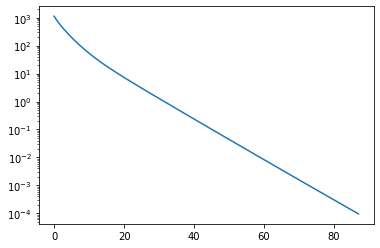

In [19]:
# 1. Количество итераций

def grad_descent(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    conv = [x]
    norm_gd = []
    for i in range(num_iter):
        h = -grad(x)
        norm_gd.append(np.linalg.norm(h))
        if jnp.linalg.norm(h) < eps:
            break
        x = x + alpha * h
        conv.append(x)
    return x, conv, i, norm_gd

x_gd, conv_gd, i_gd, norm_gd = grad_descent(f, gradf, x0, num_iter, eps, alpha)
print("Ответ: ",i_gd+1)             # +1 тк отсчет с 0
plt.semilogy([x for x in norm_gd]); plt.show()  # уменьшение нормы градиента функции

##2. Calculate number of iterations for heavy ball method

47


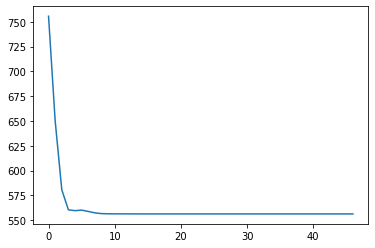

In [18]:
# 2. Метод тяжелого шарика

def heavy_ball(f, grad, x0, num_iter, eps, alpha, beta):
    x = x0.copy()
    conv = [x.copy()]
    prev_x = None
    for i in range(num_iter):
        h = -grad(x)
        if jax.numpy.linalg.norm(h) < eps:
          break
        if prev_x is None:
            prev_x = x
            x = x + alpha * h
        else:
            x, prev_x = x + alpha * h + beta * (x - prev_x), x
        conv.append(x.copy())
    return x, conv, i

x_star, conv_gd, i = heavy_ball(f, gradf, x0, num_iter, eps, alpha, beta=0.5)
print("Ответ: ",i+1)              # +1 тк отсчет с 0
plt.plot([f(x) for x in conv_gd]); plt.show()

##3. Calculate number of iterations for accelerated gradient descent method

Ответ:  34


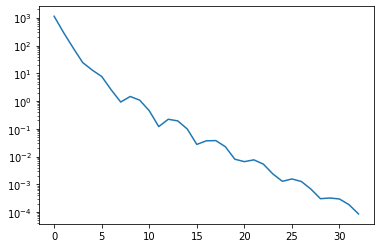

In [21]:
alpha = 3e-4              # размер шага

def accelerated_gd(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    y = x0.copy()
    conv = [x]
    norm_acc_gd = []
    prev_x = None
    for i in range(num_iter):
        h = -grad(y)
        norm_acc_gd.append(np.linalg.norm(h))
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = y + alpha * h
        else:
            x, prev_x = y + alpha * h, x
        
        y = x + (i+1.) / (i+4.) * (x - prev_x)
            
        conv.append(x)
    return x, conv, i, norm_acc_gd


x_acc_gd, conv_acc_gd, i_acc_gd, norm_acc_gd = accelerated_gd(f, gradf, x0, num_iter, eps, alpha)
print("Ответ: ",i_acc_gd+2)
# print(len(conv_acc_gd))
# plt.semilogy([f(x) for x in conv_acc_gd])  # уменьшение функции
plt.semilogy([x for x in norm_acc_gd]); plt.show()  # уменьшение нормы градиента функции

Ответ:  34


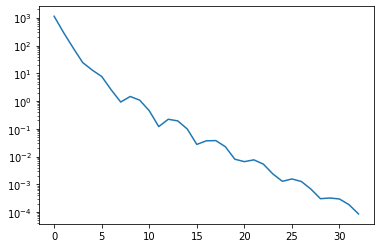

In [22]:
# 

def accelerated_gd_restart(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    y = x0.copy()
    conv = [x]
    prev_x = None
    for i in range(num_iter):
        h = -grad(y)
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = y + alpha * h
        else:
            x, prev_x = y + alpha * h, x
        if f(x) < f(prev_x):
            y = x + (i+1.) / (i+4.) * (x - prev_x)
        else:
            y = prev_x.copy()
            prev_x = None
            
        conv.append(x)
    return x, conv, i

x_acc_gd, conv_acc_gd, i_acc_gd = accelerated_gd_restart(f, gradf, x0, num_iter, eps, alpha)
print("Ответ: ",i_acc_gd+1)
# plt.semilogy([f(x) for x in conv_acc_gd])  # уменьшение нормы градиента функции
plt.semilogy([x for x in norm_acc_gd]); plt.show()  # уменьшение нормы градиента функции

##4. Calculate the iteration when Newton method begins to stagnate

Какая скорость сходимости метода Ньютона по норме градиента наблюдается?
- Линейная

145

Мне кажется, что ответ такой:  144 



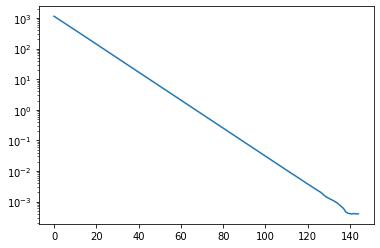

In [23]:
# 4. Стагнация в методе Ньютона

from jax.config import config                       
config.update("jax_enable_x64", False)               # возвращаю в float32

np.random.seed(0)

m = 100
n = 10
A = np.random.randn(m, n) # сгенерированная матрица
b = np.random.randn(m)    # сгенерированный вектор

x0 = jax.numpy.zeros(n)   # начальное приближение
eps = 1e-4                # точность расчета
alpha = 1e-1              # размер шага
num_iter = 500           # максимальное количество итераций

f = lambda x: (jax.numpy.linalg.norm(A@x - b))**3
gradf = jax.grad(f)

# 4. Стагнация в методе Ньютона
# https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization#Higher_dimensions
def newton_minimize(f, gradf, hessf, x0, alpha, num_iter):
    x = x0.copy()
    conv = [x]
    norm = []
    prev_norm = None
    for i in range(num_iter):
        H = hessf(x)
        g = gradf(x)
        x = x - alpha * jax.numpy.linalg.solve(H, g)

        norm.append(np.linalg.norm(g))

        if norm[-1] == prev_norm:
            # на данном этапе прошло на одну итерацию больше, тк требуемая норма получена на предыдущем шаге
            # но так как отсчет i велся с 0, то значение i на данном моменте равно номеру итерации
            break

        prev_norm = norm[-1]
        conv.append(x)
    return x, conv, norm, i

hess = jax.hessian(f)
x, conv, norm, i = newton_minimize(f, gradf, hess, x0, alpha, num_iter)
print("\nМне кажется, что ответ такой: ",i, "\n")
plt.semilogy([x for x in norm]); plt.show()